In [1134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from tqdm import tqdm

In [1135]:
n = 100

In [1136]:
def sigmoid(x, alpha):
    z = np.exp(-x+alpha)
    sig = 1 / (1 + z)
    return sig

In [1137]:
#Height, weight, age
mu = [180,80,40]
sigma_all_corr = [[20**2, 240, 100],[240,15**2,45],[100,45,10**2]]
sigma_no_cross = [[20**2, 240, 100],[240,15**2,0],[100,0,10**2]]

In [1138]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [1139]:
print(is_pos_def(sigma_no_cross))
print(is_pos_def(sigma_all_corr))

True
True


In [1140]:
data_cross_corr = np.random.multivariate_normal(mu ,sigma_all_corr, size = n)
data_no_cross = np.random.multivariate_normal(mu ,sigma_no_cross, size = n)

In [1141]:
def random_missing_distr(data):
    missing = np.random.binomial(n = 1, p=0.3, size = n)
    y_o = [d for d, m in zip(data[:,0], missing) if m ==0]
    y_m = [d for d, m in zip(data[:,0], missing) if m ==1]
    print(np.mean(y_o), np.std(y_o))
    print(np.mean(y_m), np.std(y_m))
    plt.hist(y_o)
    plt.show()
    plt.hist(y_m)
    plt.show()

def mar_missing_distr(data):
    y_o = [d for d, m in zip(data[:,0], data[:,1]) if m <=102.5] #1.5std
    y_m = [d for d, m in zip(data[:,0], data[:,1]) if m >=102.5]
    print(np.mean(y_o), np.std(y_o))
    print(np.mean(y_m), np.std(y_m))
    plt.hist(y_o)
    plt.show()
    plt.hist(y_m)
    plt.show()

183.3524143774957 19.075915255642517
183.7253180894121 21.364330349731876


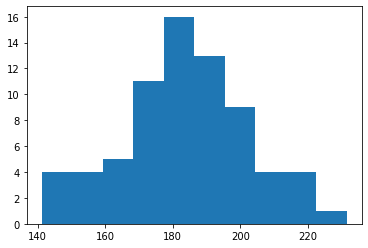

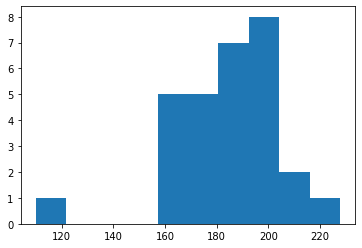

180.4975695561735 19.514951211498595
178.11195131114374 19.15365381428856


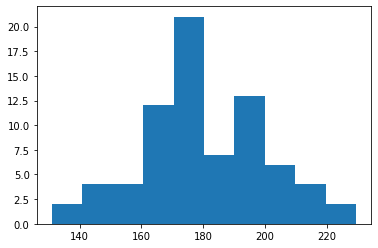

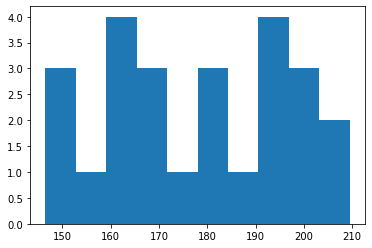

In [1142]:
random_missing_distr(data_cross_corr)
random_missing_distr(data_no_cross)

181.9876890946832 18.998273947275926
211.44503628004864 11.534153922719407


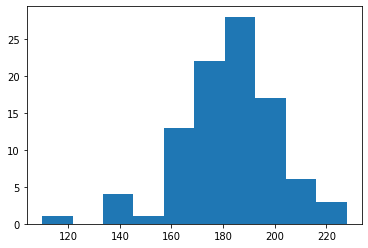

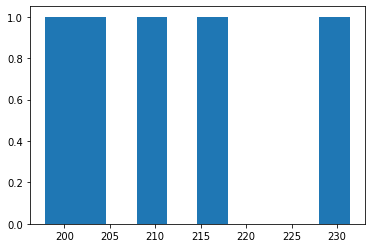

178.0080864677061 18.272551999430664
205.0520654278483 17.021391684080566


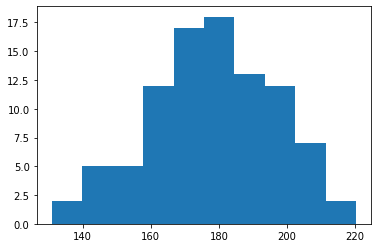

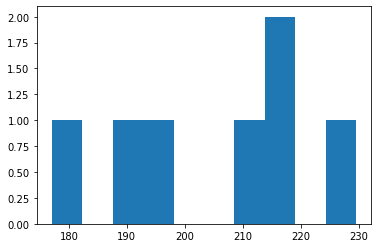

In [1143]:
mar_missing_distr(data_cross_corr)
mar_missing_distr(data_no_cross)

In [1144]:
size = 10000

In [1145]:
#Categorical data
x_1 = np.random.normal(40, 10, size = size)
x_2 = np.random.binomial(1,0.65, size = size)
y = np.around(sigmoid(x_1+x_2*20, alpha = 50)).astype(int)
synth_cat = pd.DataFrame({"y": y, "x_1":x_1, "x_2":x_2})
synth_cat_test = synth_cat.iloc[:round(0.3*size),:]
synth_cat_train = synth_cat.iloc[round(0.3*size):,:]

In [1146]:
synth_cat_test["x_2"].mode()[0]

1

In [1147]:
def confusion_matrix(true, pred):
    #Assumes numpy arrays(
    try: tpr = sum([1 if t == p and p==1 else 0 for t,p in zip(true, pred)])/(sum(true))
    except: 
        tpr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))

    try: tnr = sum([1 if t == p and p==0 else 0 for t,p in zip(true, pred)])/(len(true)-sum(true))
    except: 
        tnr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))
    fpr = 1-tnr
    fnr = 1-tpr
    return pd.DataFrame({"Predicted true": [tpr, fpr],
        "Predicted false": [fnr, tnr]}, index=["Is true", "Is false"])

In [1148]:
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
def data_remover_cat(full_data, missing_col, missing_pct, missing = "mar", impute = "cca"):
    #Missing_pct is in the range 0 to 100
    data = full_data.copy()

    if missing =="mar":
        x = data.drop(missing_col, axis = 1)
        if data[missing_col].nunique() ==2:
            clf = LogisticRegression(random_state=0).fit(x, data[missing_col])
            preds = clf.predict_proba(x)[:,1]
        else:
            clf = LinearRegression().fit(x, data[missing_col])
            preds = clf.predict(x)
        #print(preds)
        lower_percentile = np.percentile(preds, missing_pct//2)
        upper_percentile = np.percentile(preds, 100-missing_pct//2)
        print("lower", lower_percentile,
            "upper", upper_percentile)
        data["preds"] = preds
        data[missing_col] = data[missing_col].mask((data["preds"]<= lower_percentile) | (data["preds"]>= upper_percentile),
            other = np.nan)
        data.drop("preds", axis = 1, inplace = True)
        
    else:
        mcar = np.random.binomial(n=1, p=missing_pct/100, size = len(data))
        data["missing"] = [np.nan if m ==1 else 0 for m in mcar]
        data[missing_col] = data[missing_col].mask(data["missing"] == np.nan,
            other = np.nan)
        data.drop("missing", axis = 1, inplace = True)
        
    if impute =="cca":
        data.dropna(axis = 0, inplace = True)
    elif impute == "mean":
        if data[missing_col].nunique() ==2:
            #print("nans", data[missing_col].isna().sum())
            mode = data[missing_col].mode(dropna = True)[0]
            #print("mode", mode, "END")
            data[missing_col] = data[missing_col].fillna(mode)
            #print("nans", data[missing_col].isna().sum())
        else:
            mean = data[missing_col].mean(skipna = True)
            data[missing_col] = data[missing_col].fillna(mean)
    elif impute == "reg":
        pass
    elif impute == "mice_def":
        imputer = IterativeImputer(random_state=0)
        imputer.fit(data)
        data = pd.DataFrame(imputer.transform(data), columns = data.columns)
        #print(data[missing_col].unique())
        if data[missing_col].nunique() ==2:
            data[missing_col] = data[missing_col].round()
        #print(data[missing_col].unique())
    elif impute == "mice_reg":
        if data[missing_col].nunique() ==2:
            model = LogisticRegression(random_state=0, max_iter=300)
            imputer = IterativeImputer(estimator = model, random_state=0)
            imputer.fit(data)
            data = pd.DataFrame(imputer.transform(data), columns = data.columns)
            #print(data[missing_col].unique())
        else:
            model = LinearRegression()
            imputer = IterativeImputer(estimator = model, random_state=0)
            imputer.fit(data)
            data = pd.DataFrame(imputer.transform(data), columns = data.columns)
    return data




In [1149]:
#TODO test or consider expanding with SKlearn simple imputer
def mean_imputer(full_data, missing):
    data = full_data.copy()
    #Check if data is binary categorical or continuous
    temp = data[data[missing]==np.nan]
    mode = data[missing].mode()
    data.loc[temp, missing] = mode
    return data
    

In [1150]:
#TODO test
def regression_imputer(full_data, missing):
    #Check if data is binary categorical or continuous.
    pass

In [1151]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

#TODO figure out a good set of hyperparameters and a response on how to tune them
# Perhaps irrelevant since we are looking at difference in performance due to missing data?
init_models = {"log_reg": LogisticRegression(random_state=0, max_iter=500),
    "lin_reg":LinearRegression(),
    "svm":LinearSVC(random_state=0, tol=1e-5),
    "knn":KNeighborsClassifier(n_neighbors=3),
    "rf_cat": RandomForestClassifier(max_depth=4, random_state=0),
    "rf_cont": RandomForestRegressor(max_depth=4, random_state=0)}
    
def test_bench(train, test, pred:str, missing:str, sensitive:str, corrective:str = "cca", pred_var_type:str="cat", miss_var_type:str="cat"):
    #sensitive var
    class_0_test = test[test[sensitive]==0]
    class_1_test = test[test[sensitive]==1]
    

    #print("class_0",sum(class_0_test[pred]))
    #print("class_1",sum(class_1_test[pred]))
    results = {}
    percentiles = [i for i in range(1,16)]+[j for j in range(20, 100, 10)]

    #TODO add xgboost, neural network
    if pred_var_type =="cat":
        models = ["log_reg", "rf_cat", "svm", "knn"]
    else:
        models = ["lin_reg", "rf_cont", "svm"] 
    #Run with full data
    
    for m in tqdm(models):
        predictions_0 = init_models[m].fit(train.drop(pred, axis = 1),
            train[pred]).predict(class_0_test.drop(pred, axis = 1))
        predictions_1 = init_models[m].fit(train.drop(pred, axis = 1),
            train[pred]).predict(class_1_test.drop(pred, axis = 1))
        results[m+"_0"] = confusion_matrix(class_0_test[pred], predictions_0)
        results[m+"_1"] = confusion_matrix(class_1_test[pred], predictions_1)
        for p in percentiles:
            for imp in ["cca", "mice_def", "mean"]:
                #print("length", len(data_mcar))
                #print("P: ", p)
                #print(imp)
                data_mcar = data_remover_cat(train, missing, p, missing="mcar", impute = imp)
                predictions_0 = init_models[m].fit(data_mcar.drop(pred, axis = 1),
                data_mcar[pred]).predict(class_0_test.drop(pred, axis = 1))
                predictions_1 = init_models[m].fit(data_mcar.drop(pred, axis = 1),
                data_mcar[pred]).predict(class_1_test.drop(pred, axis = 1))
                results[m+"_mcar_"+imp+"_"+str(p)+"_0"] = confusion_matrix(class_0_test[pred], predictions_0)
                results[m+"_mcar_"+imp+"_"+str(p)+"_1"] = confusion_matrix(class_1_test[pred], predictions_1)

                
                data_mar = data_remover_cat(train, missing, p, missing="mar", impute = imp)
                #print("sum", sum(np.array(data_mar["y"])), "length", len(data_mar))
                #print(data_mar.isna().sum())
                predictions_0 = init_models[m].fit(data_mar.drop(pred, axis = 1),
                data_mar[pred]).predict(class_0_test.drop(pred, axis = 1))
                predictions_1 = init_models[m].fit(data_mar.drop(pred, axis = 1),
                data_mar[pred]).predict(class_1_test.drop(pred, axis = 1))
                results[m+"_mar_"+imp+"_"+str(p)+"_0"] = confusion_matrix(class_0_test[pred], predictions_0)
                results[m+"_mar_"+imp+"_"+str(p)+"_1"] = confusion_matrix(class_1_test[pred], predictions_1)
            
    return results

        

        

In [1155]:
print("Class 1: ",len(synth_cat_train[synth_cat_train["x_2"]==1])/len(synth_cat_train) ,
    "\nClass 2: ", len(synth_cat_train[synth_cat_train["x_2"]==0])/len(synth_cat_train))
temp = synth_cat_train.copy()
temp = data_remover_cat(temp, "x_1", 30)
print("Class 1: ",len(temp[temp["x_2"]==1])/len(temp) ,
    "\nClass 2: ", len(temp[temp["x_2"]==0])/len(temp))


Class 1:  0.6677142857142857 
Class 2:  0.3322857142857143
Class 1:  0 
Class 2:  0


In [1153]:
res2 = test_bench(synth_cat_train, synth_cat_test, "y", "x_1", "x_2")

  0%|          | 0/4 [00:00<?, ?it/s]

      y        x_1  x_2
3000  0  45.412832    0
3001  0  40.212678    0
3002  0  41.516337    0
3003  0  46.353485    0
3004  0  39.450833    0


  0%|          | 0/4 [00:04<?, ?it/s]


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [1156]:
res = test_bench(synth_cat_train, synth_cat_test, "y", "x_2", "x_2")

  0%|          | 0/4 [00:00<?, ?it/s]

      y        x_1  x_2
3000  0  45.412832    0
3001  0  40.212678    0
3002  0  41.516337    0
3003  0  46.353485    0
3004  0  39.450833    0


 25%|██▌       | 1/4 [00:10<00:30, 10.25s/it]

      y        x_1  x_2
3000  0  45.412832    0
3001  0  40.212678    0
3002  0  41.516337    0
3003  0  46.353485    0
3004  0  39.450833    0


 50%|█████     | 2/4 [01:22<01:32, 46.43s/it]C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


      y        x_1  x_2
3000  0  45.412832    0
3001  0  40.212678    0
3002  0  41.516337    0
3003  0  46.353485    0
3004  0  39.450833    0


C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Program

      y        x_1  x_2
3000  0  45.412832    0
3001  0  40.212678    0
3002  0  41.516337    0
3003  0  46.353485    0
3004  0  39.450833    0


100%|██████████| 4/4 [02:00<00:00, 30.20s/it]


In [1157]:
#res.keys()

In [1158]:
import collections
def plotting(models, correctives, results):
    for m in models:
        for c in correctives:
            tpr_mar = {"0":{}, "1": {}}
            tnr_mar = {"0":{}, "1": {}}
            tpr_mcar = {"0":{}, "1": {}}
            tnr_mcar = {"0":{}, "1": {}}
            for key, value in results.items():
                if m+"_mar" in key and c in key:
                    if key[-1] =="0":
                        tpr_mar["0"][int(key.split("_")[-2])] = value.iloc[0,0]
                        tnr_mar["0"][int(key.split("_")[-2])] = value.iloc[1,1]
                    else:
                        tpr_mar["1"][int(key.split("_")[-2])] = value.iloc[0,0]
                        tnr_mar["1"][int(key.split("_")[-2])] = value.iloc[1,1]
                elif m+"_mcar" in key and c in key:
                    try:
                        if key[-1] =="0":
                            tpr_mcar["0"][int(key.split("_")[-2])] = value.iloc[0,0]
                            tnr_mcar["0"][int(key.split("_")[-2])] = value.iloc[1,1]
                        else:
                            tpr_mcar["1"][int(key.split("_")[-2])] = value.iloc[0,0]
                            tnr_mcar["1"][int(key.split("_")[-2])] = value.iloc[1,1]
                    except Exception as e:
                        print("key", key, "exception", e)
            tpr_mar = collections.OrderedDict(sorted(tpr_mar.items()))
            plt.plot(list(tpr_mar["0"].keys()), list(tpr_mar["0"].values()), label = m+"TPR MAR class 0")
            plt.plot(list(tnr_mar["0"].keys()), list(tnr_mar["0"].values()), label = m+"TNR MAR class 0")
            plt.plot(list(tpr_mar["1"].keys()), list(tpr_mar["1"].values()), label = m+"TPR MAR class 1")
            plt.plot(list(tnr_mar["1"].keys()), list(tnr_mar["1"].values()), label = m+"TNR MAR class 1")
            plt.title(m+"_"+c+"_MAR")
            plt.legend()
            plt.show()
            plt.plot(list(tpr_mcar["0"].keys()), list(tpr_mcar["0"].values()), label = m+"TPR MCAR class 0")
            plt.plot(list(tnr_mcar["0"].keys()), list(tnr_mcar["0"].values()), label = m+"TNR MCAR class 0")
            plt.plot(list(tpr_mcar["1"].keys()), list(tpr_mcar["1"].values()), label = m+"TPR MCAR class 1")
            plt.plot(list(tnr_mcar["1"].keys()), list(tnr_mcar["1"].values()), label = m+"TNR MCAR class 1")
            plt.title(m+"_"+c+"_MCAR")
            plt.legend()
            plt.show()


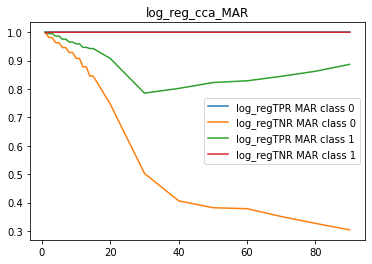

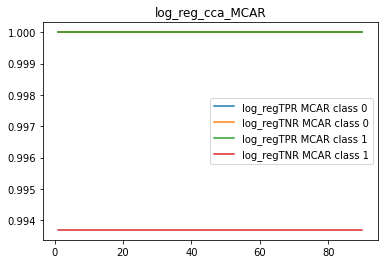

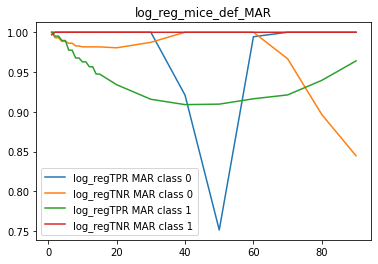

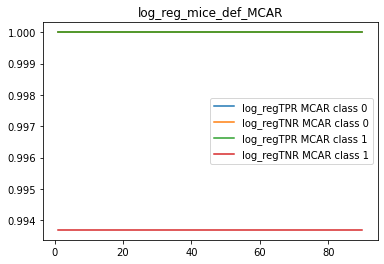

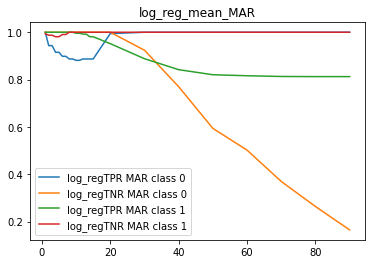

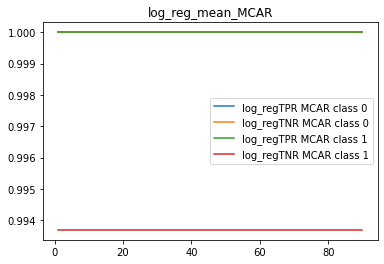

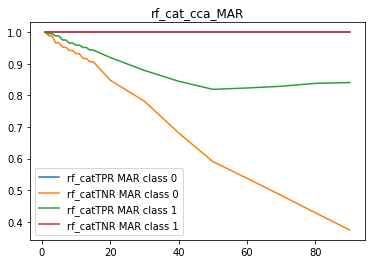

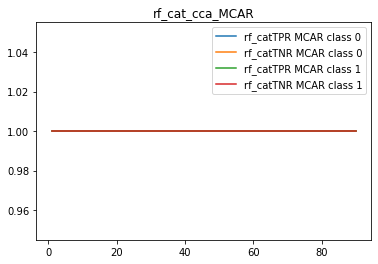

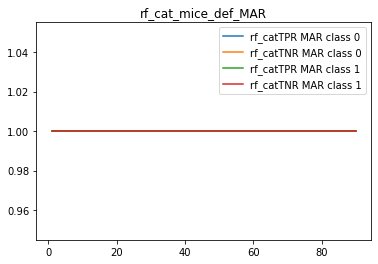

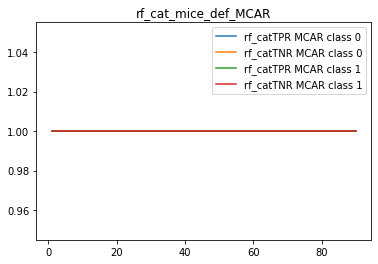

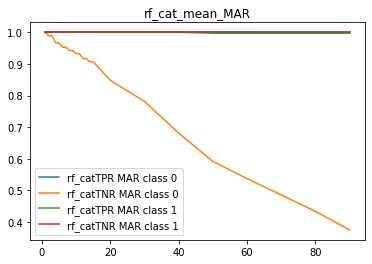

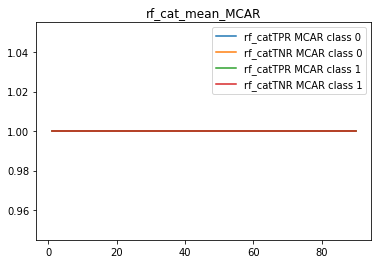

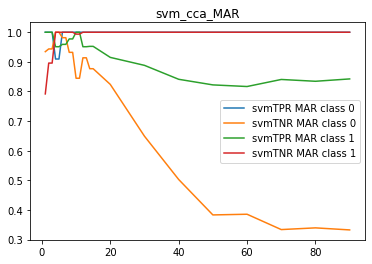

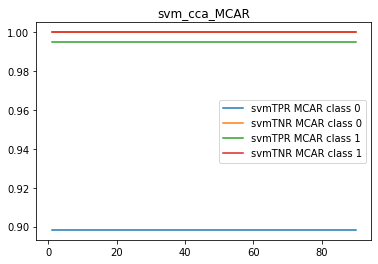

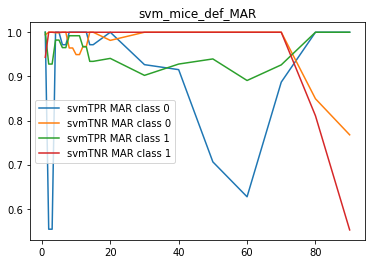

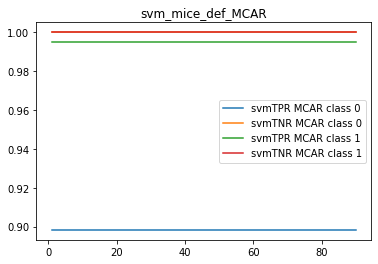

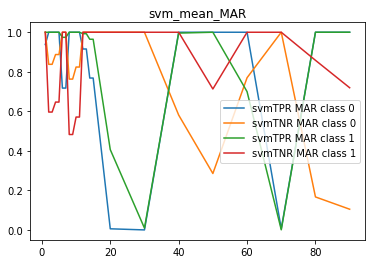

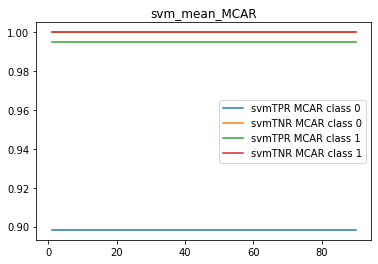

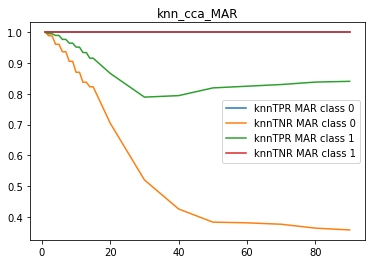

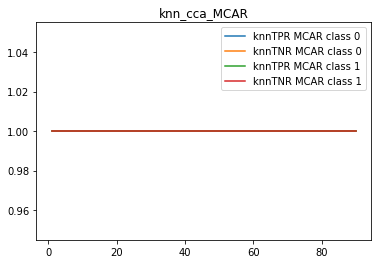

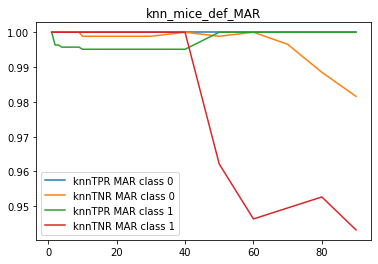

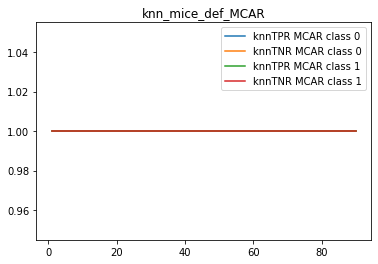

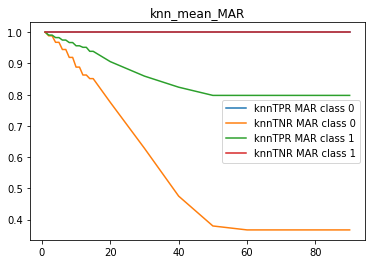

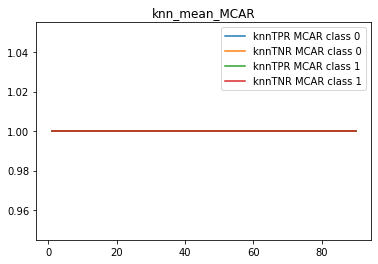

In [1159]:
try:
    plotting(["log_reg", "rf_cat", "svm", "knn"],["cca", "mice_def", "mean"], res)
except Exception as e:
    print(e)

In [ ]:
res2 = test_bench(synth_cat_train, synth_cat_test, "y", "x_1")

  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.